<a href="https://colab.research.google.com/github/soulayman-al-abdallah/ML-Petro-well-log-lithology/blob/main/part_1_Data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets: 
- **Lithology code data.xlsx** : A schedule defining each geological lithology with an integer unique value (i.e. 3,10,32...)
- **GEOLINK_Lithology and wells NORTH SEA** : A directory containing many LAS files, each LAS file presents a well and features 25+ relevant logs data

Our main tasks in this notebook focuses on the 2nd dataset as follow:

- Data cleaning and determining the common 10 features present in different LAS files
- Applying EDA
- Preprocessing Outliers and Missing Values

We end the work here by saving 2 dataframes: **Litho_code.csv** and **df_main.csv**



---



---



---



# Importing Modules


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import time
import multiprocessing
!pip install lasio
import lasio
import os
from os import path
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.7 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Reading data

## Lithology code data

In [ ]:
file_path = '/content/gdrive/MyDrive/Dev tools/Data - NorthSea Electrofacies/Lithology code data.xlsx'

litho_code = pd.read_excel(file_path)
litho_code.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Lithology,Color,Lithology Attribute,Abbreviation
1,Aeolian Sandstone,LightYellow,CrossBedded Sand,35.0
2,Anhydrite,Light Magenta,Anhydrite,22.0
3,Argillaceous Limestone,Dodger Blue,Chalk,12.0
4,Arkose,LightGoldenrod,Gravel,36.0


In [ ]:
#Use the first row as columns titles
litho_code.columns = litho_code.iloc[0]

#Dropping the first row aftrwards
litho_code.drop(index=0 , inplace=True)
litho_code.head()

,Lithology,Color,Lithology Attribute,Abbreviation
1,Aeolian Sandstone,LightYellow,CrossBedded Sand,35.0
2,Anhydrite,Light Magenta,Anhydrite,22.0
3,Argillaceous Limestone,Dodger Blue,Chalk,12.0
4,Arkose,LightGoldenrod,Gravel,36.0
5,Basement,Salmon,Intrusive,23.0


## Las files

In [4]:
#reading

def read_las_directory(path_to_folder):
    """Reads all las files on the given folder."""

    main_name = {}
    for i in (os.listdir(path_to_folder)):
        main_name[os.path.splitext(i)[0]] = lasio.read(os.path.join(path_to_folder, i))
    return main_name


path = '/content/gdrive/MyDrive/Dev tools/Data - NorthSea Electrofacies/GEOLINK_Lithology and wells NORTH SEA'
npd_wells = read_las_directory(path)



---



### Dataframe preparation

In [25]:
#inspecting

print('Number of Las Files read: ' + str(len(npd_wells)))
print('---------------------------')
print('Some Las files ID: ' + str(list(npd_wells.keys())[:4])) # A list of some of the key values = id values
print('---------------------------')
print('Some Las files objects holding info: ' + str(list(npd_wells.values())[:4])) # A list of some of the dict values
print('---------------------------')
print(str(npd_wells['34_10-19'].curves))        # Available curves = features for one of the ids

Number of Las Files read: 223
---------------------------
Some Las files ID: ['16_10-1', '16_8-1', '16_7-7 S', '15_9-4']
---------------------------
Some Las files objects holding info: [<lasio.las.LASFile object at 0x7f6963a80650>, <lasio.las.LASFile object at 0x7f6963121150>, <lasio.las.LASFile object at 0x7f6963a9d690>, <lasio.las.LASFile object at 0x7f6963a52750>]
---------------------------
Mnemonic           Unit   Value  Description        
--------           ----   -----  -----------        
DEPT               m             DEPTH              
LITHOLOGY_GEOLINK  _             Lithology_geolink  
CALI               in            CALI               
DRHO               g/cm3         DRHO               
NPHI               m3/m3         NPHI               
RHOB               g/cm3         RHOB               
GR                 gAPI          GR                 
DTC                us/ft         DTC                
RDEP               ohm.m         RDEP               
SP                



---



In [ ]:
#Converting las dictionary to dataframe

npd_wells_df = {}

for id in list(npd_wells.keys()):

    npd_wells_df[id] = npd_wells[id].df()

    #Creating Main Dataframe
    npd_wells_df[id]['WELL_NAME'] = id

    #Converting Depth to a Column
    npd_wells_df[id]['DEPTH'] = npd_wells_df[id].index

In [ ]:
# las dict example
npd_wells['15_9-12']

In [ ]:
# df example
npd_wells_df['15_9-12']

,LITHOLOGY_GEOLINK,CALI,DRHO,NPHI,RHOB,GR,DTC,DTE,RDEP,SP,RSHA,RXO,RMED,WELL_NAME,DEPTH
DEPT,,,,,,,,,,,,,,,
493.493134,NaN,19.406000,-0.708,NaN,1.789,64.497482,167.582153,50815100.0,1.574993,0.694700,1.546029,NaN,1.546029,15_9-12,493.493134
493.645538,NaN,19.406000,-0.722,NaN,1.754,62.406261,167.425064,50761636.0,1.569011,0.445339,1.570030,NaN,1.570030,15_9-12,493.645538
493.797943,NaN,19.406000,-0.620,NaN,1.778,62.629055,167.808395,50886056.0,1.578010,0.727901,1.594994,NaN,1.594994,15_9-12,493.797943
493.950348,NaN,19.452999,-0.648,NaN,1.642,65.998596,169.244873,51314492.0,1.586024,1.474898,1.589930,NaN,1.589930,15_9-12,493.950348
494.102722,NaN,19.452999,-0.685,NaN,1.563,64.997223,170.635086,51763464.0,1.603011,-0.023000,1.540016,NaN,1.540016,15_9-12,494.102722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3751.957031,NaN,7.555000,0.085,0.13574,2.586,NaN,NaN,NaN,3.363003,70.302795,3.159997,NaN,3.159997,15_9-12,3751.957031
3752.109375,NaN,7.555000,0.085,0.13574,2.586,NaN,NaN,NaN,3.364997,70.799194,3.158000,NaN,3.158000,15_9-12,3752.109375
3752.261963,NaN,7.555000,0.085,0.13574,2.586,NaN,NaN,NaN,3.363006,71.544258,3.158000,NaN,3.158000,15_9-12,3752.261963


⚓ The Dataframe is somehow ready, but we need to chck the balance of data among the different features=logs, to see if we keep it or edit the present features.



---



### Feature Selection

In [ ]:
#Analyzing the data balance of features = logs by well

wlist = list(npd_wells_df.keys())
unique_logs = []

for i in wlist:
    temp = npd_wells_df[i].columns
    unique_logs.extend(temp)

unique_logs = list(set(unique_logs))

print('List of unique logs: ', unique_logs, '\n')
print('Number of unique logs: ', len(unique_logs))

List of unique logs:  ['BS', 'MUDWEIGHT', 'DCAL', 'DTS', 'WELL_NAME', 'DEPTH', 'ROP', 'RDEP', 'NPHI', 'DTE', 'GR', 'SGR', 'DT', 'TGAS', 'RXO', 'URAN', 'RHOB', 'LITHOLOGY_GEOLINK', 'DTC', 'PEF', 'RHOM', 'CGR', 'THOR', 'RMIC', 'RSHA', 'SP', 'DRHO', 'RMED', 'CALI'] 

Number of unique logs:  29


In [ ]:
#counting the feature presence FREQUENCY in the 223 files = parts of the big npd_wells_df dictionary

log_dict = dict.fromkeys(unique_logs, 0)

for l in list(log_dict.keys()):                       # log_dict                            {'GR': 0,'DCAL': 0,'URAN': 0,'TGAS': 0, ....}
    
    for w in npd_wells_df.keys():                     # npd_wells_df.keys()                 ['25_8-9', '31_4-2', '25_6-2', '30_3-4 R', '34_7-15 S', ....]

        if l in npd_wells_df[w].columns:              # npd_wells_df['15_9-12'].columns     ['LITHOLOGY_GEOLINK', 'CALI', 'DRHO', 'NPHI', 'RHOB', 'GR', 'DTC', 'DTE','RDEP', 'SP', 'RSHA', 'RXO', 'RMED', 'WELL_NAME', 'DEPTH']

            log_dict[l] = log_dict[l] + 1             # increment the matching feature = column name by 1


print(log_dict)

{'BS': 106, 'MUDWEIGHT': 14, 'DCAL': 35, 'DTS': 49, 'WELL_NAME': 223, 'DEPTH': 223, 'ROP': 53, 'RDEP': 204, 'NPHI': 188, 'DTE': 59, 'GR': 205, 'SGR': 18, 'DT': 7, 'TGAS': 1, 'RXO': 14, 'URAN': 34, 'RHOB': 200, 'LITHOLOGY_GEOLINK': 223, 'DTC': 198, 'PEF': 91, 'RHOM': 4, 'CGR': 1, 'THOR': 34, 'RMIC': 35, 'RSHA': 154, 'SP': 147, 'DRHO': 187, 'RMED': 200, 'CALI': 196}


In [ ]:
#using the frequency dict in a df creation to visualize each feature's presence percentage

log_df = pd.DataFrame(log_dict.items(), columns=['logs', 'count'])
log_df['percent'] = (log_df['count'] / 223)*100

log_df.head()

,logs,count,percent
0,BS,106,47.533632
1,MUDWEIGHT,14,6.278027
2,DCAL,35,15.695067
3,DTS,49,21.973094
4,WELL_NAME,223,100.000000


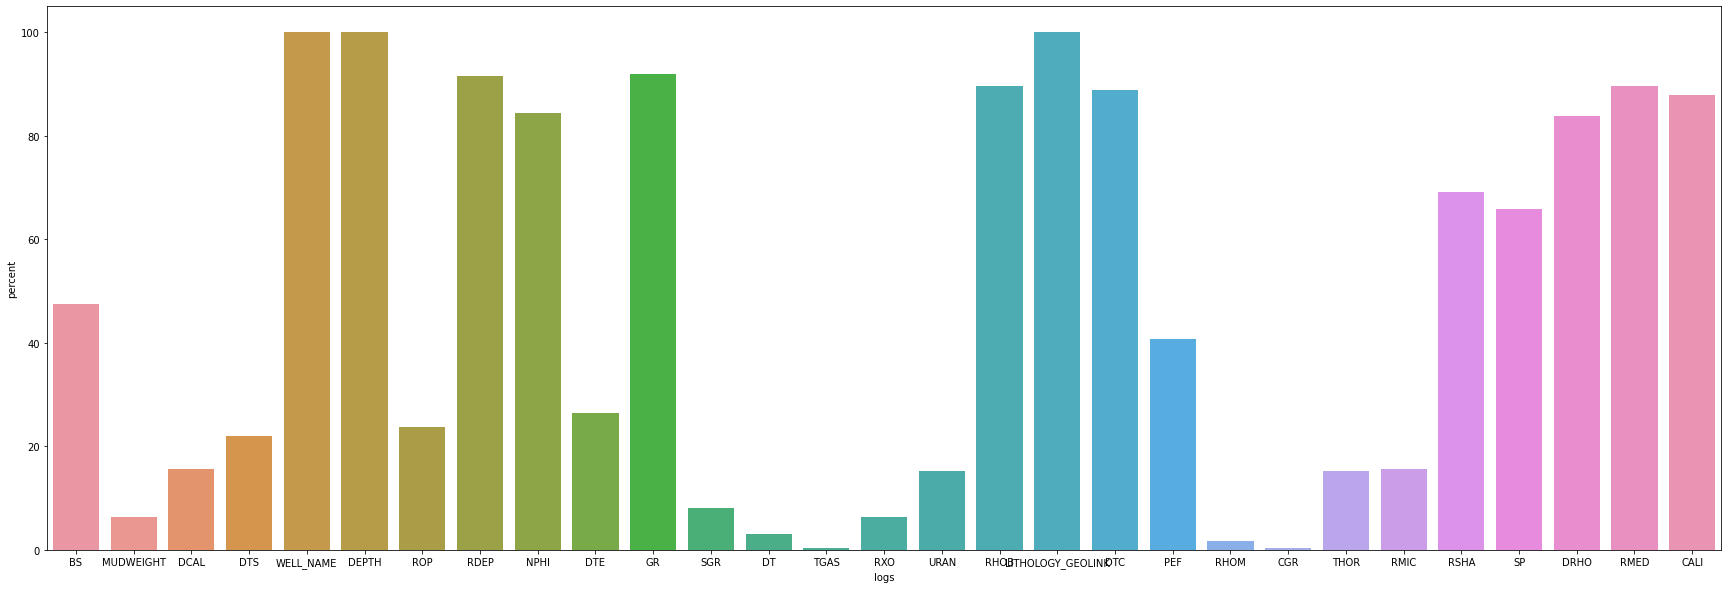

In [ ]:
plt.figure(figsize=(30,10))
sns.barplot(x='logs', y='percent', data=log_df)

We will select **the most frequent features**=logs:

['DEPTH','LITHOLOGY_GEOLINK', 'CALI', 'NPHI', 'RHOB', 'GR', 'DTC', 'RDEP', 'RMED', 'WELL_NAME']



---



### Finalizing Dataframe

In [ ]:
# selected logs
logs_list = ['DEPTH','LITHOLOGY_GEOLINK', 'CALI', 'NPHI', 'RHOB', 'GR', 'DTC', 'RDEP', 'RMED', 'WELL_NAME']

#creating an empty dataframe
df_main = pd.DataFrame(columns= logs_list)

#filling dataframe
for id in list(npd_wells_df.keys()):                                                    # npd_wells_df.keys()     ['25_8-9', '31_4-2', '25_6-2', '30_3-4 R', '34_7-15 S', ...]

  matching_logs_list = []
  for i in range(len(logs_list)):
    if logs_list[i] in npd_wells_df[id].columns:                                        # npd_wells_df['15_9-12'].columns     ['LITHOLOGY_GEOLINK', 'CALI', 'DRHO', 'NPHI', 'RHOB', 'GR', 'DTC', 'DTE','RDEP', 'SP', 'RSHA', 'RXO', 'RMED', 'WELL_NAME', 'DEPTH']

      matching_logs_list.append(logs_list[i])                                           # Adding the matching logs to a selection list

  df_main = df_main.append(npd_wells_df[id][matching_logs_list], ignore_index=True)     # Appending data of matching_logs_list columns, to a new df, from the old df

In [ ]:
print(df_main.shape)
df_main.head(3)

(3147162, 10)


,DEPTH,LITHOLOGY_GEOLINK,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,WELL_NAME
0,1150.001831,NaN,12.992999,0.609459,1.993,NaN,89.681007,NaN,NaN,35_11-10
1,1150.154297,NaN,13.020000,0.575707,1.974,76.547997,88.305000,691.920349,0.882822,35_11-10
2,1150.306641,NaN,13.057000,0.533268,2.012,80.304985,89.204002,729.229492,1.385391,35_11-10


In [ ]:
df_main.tail(3)

,DEPTH,LITHOLOGY_GEOLINK,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,WELL_NAME
3147159,2802.968994,NaN,8.641,0.0752,-1.712,NaN,NaN,4.293,NaN,34_10-12
3147160,2803.121338,NaN,8.641,0.0752,-1.712,NaN,NaN,NaN,NaN,34_10-12
3147161,2803.273926,NaN,8.641,0.0752,-1.712,NaN,NaN,NaN,NaN,34_10-12


In [ ]:
df_main.isnull().sum()

DEPTH                      0
LITHOLOGY_GEOLINK    1496212
CALI                  204648
NPHI                 1253070
RHOB                  372447
GR                     39105
DTC                   210475
RDEP                   73604
RMED                  202844
WELL_NAME                  0
dtype: int64



---



# Exploratory Data Analysis

## General Statistics

In [ ]:
df_main.head()

,DEPTH,LITHOLOGY_GEOLINK,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED,WELL_NAME
0,1150.001831,NaN,12.992999,0.609459,1.993,NaN,89.681007,NaN,NaN,35_11-10
1,1150.154297,NaN,13.020000,0.575707,1.974,76.547997,88.305000,691.920349,0.882822,35_11-10
2,1150.306641,NaN,13.057000,0.533268,2.012,80.304985,89.204002,729.229492,1.385391,35_11-10
3,1150.458984,NaN,13.058001,0.517751,1.997,80.808594,86.650002,863.258118,1.374052,35_11-10
4,1150.611450,NaN,13.057000,0.495189,1.989,83.272003,87.490005,8.905299,1.669051,35_11-10


In [ ]:
nRow, nCol = df_main.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 3147162 rows and 10 columns


In [ ]:
df_main.describe()

,DEPTH,LITHOLOGY_GEOLINK,CALI,NPHI,RHOB,GR,DTC,RDEP,RMED
count,3.147162e+06,1.650950e+06,2.942514e+06,1.894092e+06,2.774715e+06,3.108057e+06,2.936687e+06,3.073558e+06,2.944318e+06
mean,2.178031e+03,7.425249e+00,1.342559e+01,1.751375e+00,2.273573e+00,6.598313e+01,1.141344e+02,3.263110e+01,5.127361e+01
std,1.038157e+03,4.628714e+00,4.065481e+00,1.408550e+02,3.268230e-01,4.916798e+01,3.454971e+01,4.901243e+02,2.809883e+04
min,8.015202e+01,1.000000e+00,-9.834000e+00,-1.009700e-01,-1.984000e+00,-9.990000e+02,-3.102476e+02,-9.999000e+03,-4.230000e-01
25%,1.368847e+03,5.000000e+00,1.026520e+01,2.254500e-01,2.083600e+00,4.426330e+01,8.761197e+01,9.240000e-01,9.133000e-01
50%,2.088328e+03,6.000000e+00,1.284234e+01,3.220202e-01,2.291000e+00,6.287677e+01,1.116960e+02,1.455498e+00,1.459000e+00
75%,2.912315e+03,1.100000e+01,1.722600e+01,4.248798e-01,2.481900e+00,8.396545e+01,1.432239e+02,2.552900e+00,2.642121e+00
max,5.477854e+03,3.400000e+01,4.063500e+01,1.530410e+05,1.916629e+02,3.279053e+04,9.881560e+02,7.450856e+04,1.968300e+07




---



## Balance of target variable

The target variable is: **LITHOLOGY_GEOLINK**

In [ ]:
# the possible values of the LITHOLOGY_GEOLINK target variable
df_main['LITHOLOGY_GEOLINK'].value_counts()

5.0     380624
6.0     362936
13.0    179289
7.0     114576
2.0     113484
3.0      89793
11.0     70699
12.0     70647
4.0      61089
1.0      47890
19.0     38727
16.0     32387
21.0     29300
9.0      25582
10.0     14992
18.0      5964
22.0      3785
15.0      3477
26.0      2620
17.0      1927
33.0       865
32.0       230
34.0        54
20.0        10
30.0         2
24.0         1
Name: LITHOLOGY_GEOLINK, dtype: int64

Text(0.5, 1.0, 'Lithology Classes - Target Variable Balance')

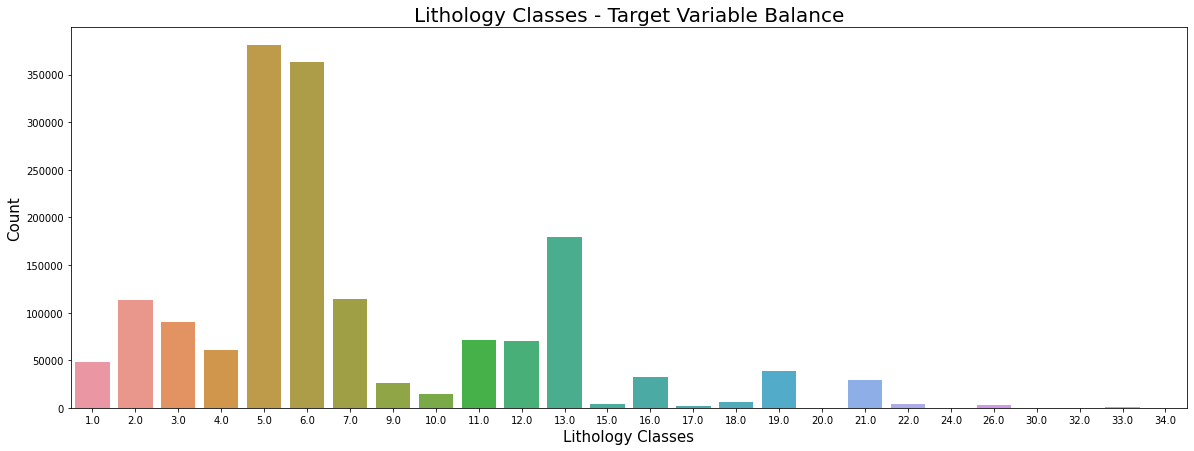

In [ ]:
#visualizing the value counts of the target variable

plt.figure(figsize=(20,7))

sns.barplot(x=df_main['LITHOLOGY_GEOLINK'].value_counts().index,
            y=df_main['LITHOLOGY_GEOLINK'].value_counts())
plt.xlabel('Lithology Classes', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Lithology Classes - Target Variable Balance', fontsize=20)

⚓ We can see that:
We have an imbalance among the target variable data



---



## Correlation between features

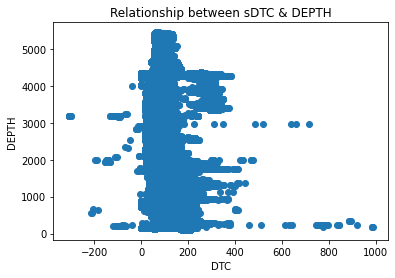

The correlation factor btw DTC and DEPTH is:  -0.6785870974138587


In [ ]:
# correlation btw 2 features
plt.plot('DTC','DEPTH', data= df_main,linestyle='none',  marker='o')
plt.xlabel('DTC')
plt.ylabel('DEPTH')
plt.title('Relationship between sDTC & DEPTH')

plt.show()

print('The correlation factor btw DTC and DEPTH is: ', df_main['DTC'].corr(df_main['DEPTH']))

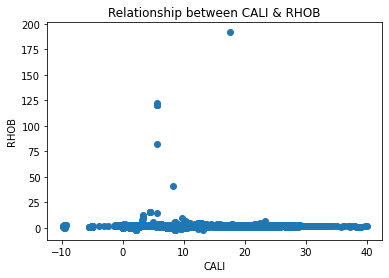

The correlation factor btw CALI and RHOB is:  -0.39720072649148486


In [ ]:
# correlation btw 2 features
plt.plot('CALI','RHOB', data= df_main,linestyle='none',  marker='o')
plt.xlabel('CALI')
plt.ylabel('RHOB')
plt.title('Relationship between CALI & RHOB')

plt.show()

print('The correlation factor btw CALI and RHOB is: ', df_main['CALI'].corr(df_main['RHOB']))

(8.9, -0.5)

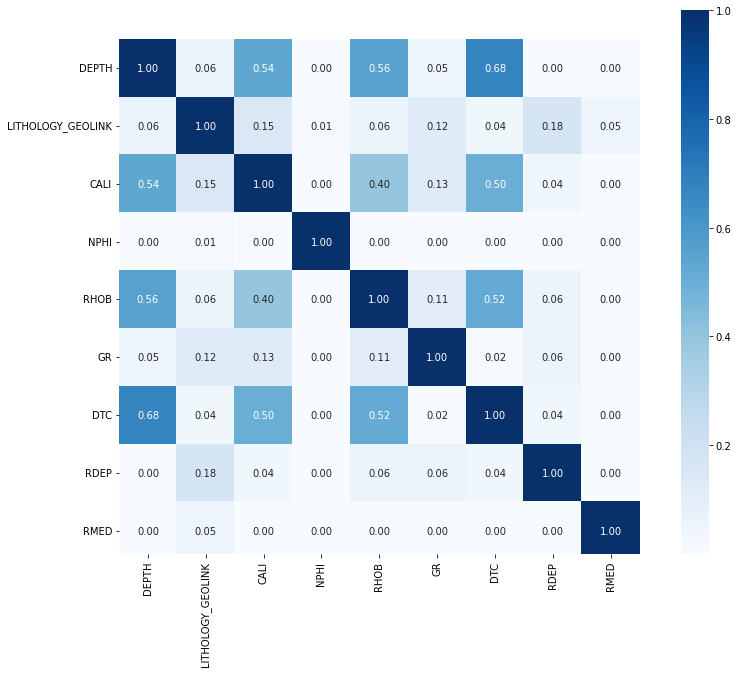

In [ ]:
# correlation matrix btw all features

corrmat_df = abs(df_main.corr()) # absolute correlation

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corrmat_df, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, cmap='Blues')

ax.set_ylim(len(corrmat_df)-0.1, -0.5)

⚓ In general we have extremely low correlation btwn all the features except the correlations btw DTC-DEPTH-RHOB-CALI features, which can be considered somehow low.



---



## Distribution

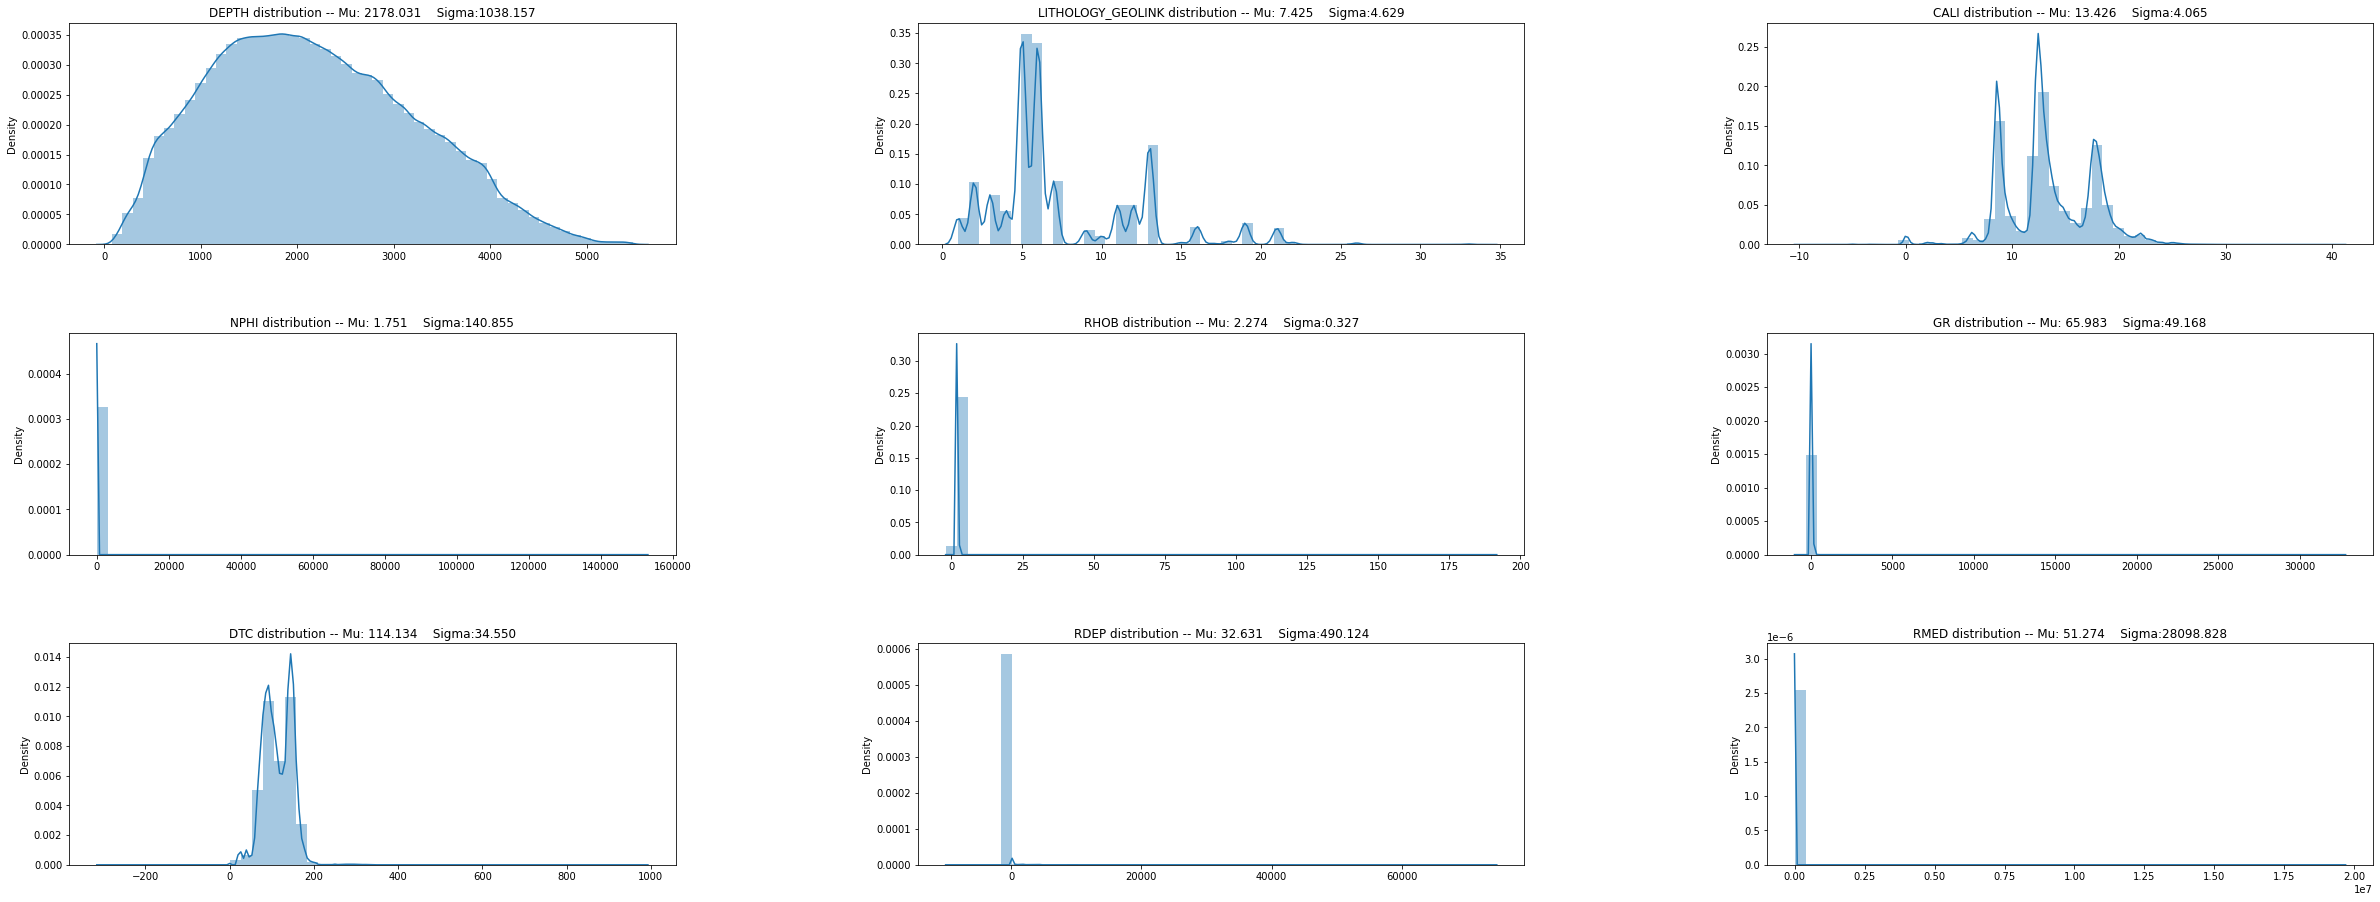

In [ ]:
#plotting the distribution of the features values = logs values

plt.figure(figsize=(40,20))

for i in range(len(df_main.columns)):
  if df_main.columns[i] != 'WELL_NAME' :
    plt.subplot(4,3,(i+1))
    feat = df_main.columns[i]                                                       # df_main.columns are ['DEPTH', 'LITHOLOGY_GEOLINK', 'CALI', ....]
    n_n_values = df_main[df_main[feat].notnull()][feat].values                      # df_main[df_main['CALI'].notnull()]['CALI'].values         array holding only notnull values of 'CALI' feature   [17.96999931, 17.96999931, 17.97100067, ...]
    (mu, sigma) = stats.norm.fit(n_n_values)
    sns.distplot(n_n_values)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.title(str(feat) + ' distribution -- Mu: '+ "{:.3f}".format(mu) + '    Sigma:' + "{:.3f}".format(sigma) )
    #print("------------ {} ----------- done-----------".format(feat))

plt.show()



---



# Preprocessing

## Outliers

z-score of a specific value, is the number of standard deviations, this point is far from the mean (calculated after standarizing all the values in a way that the mean becomes 0 and the std = 1)

**how does this help in identifying the outliers? **

Well, while calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

In [ ]:
df_main.shape

(3147162, 10)

In [ ]:
df_main.columns

Index(['DEPTH', 'LITHOLOGY_GEOLINK', 'CALI', 'NPHI', 'RHOB', 'GR', 'DTC',
       'RDEP', 'RMED', 'WELL_NAME'],
      dtype='object')

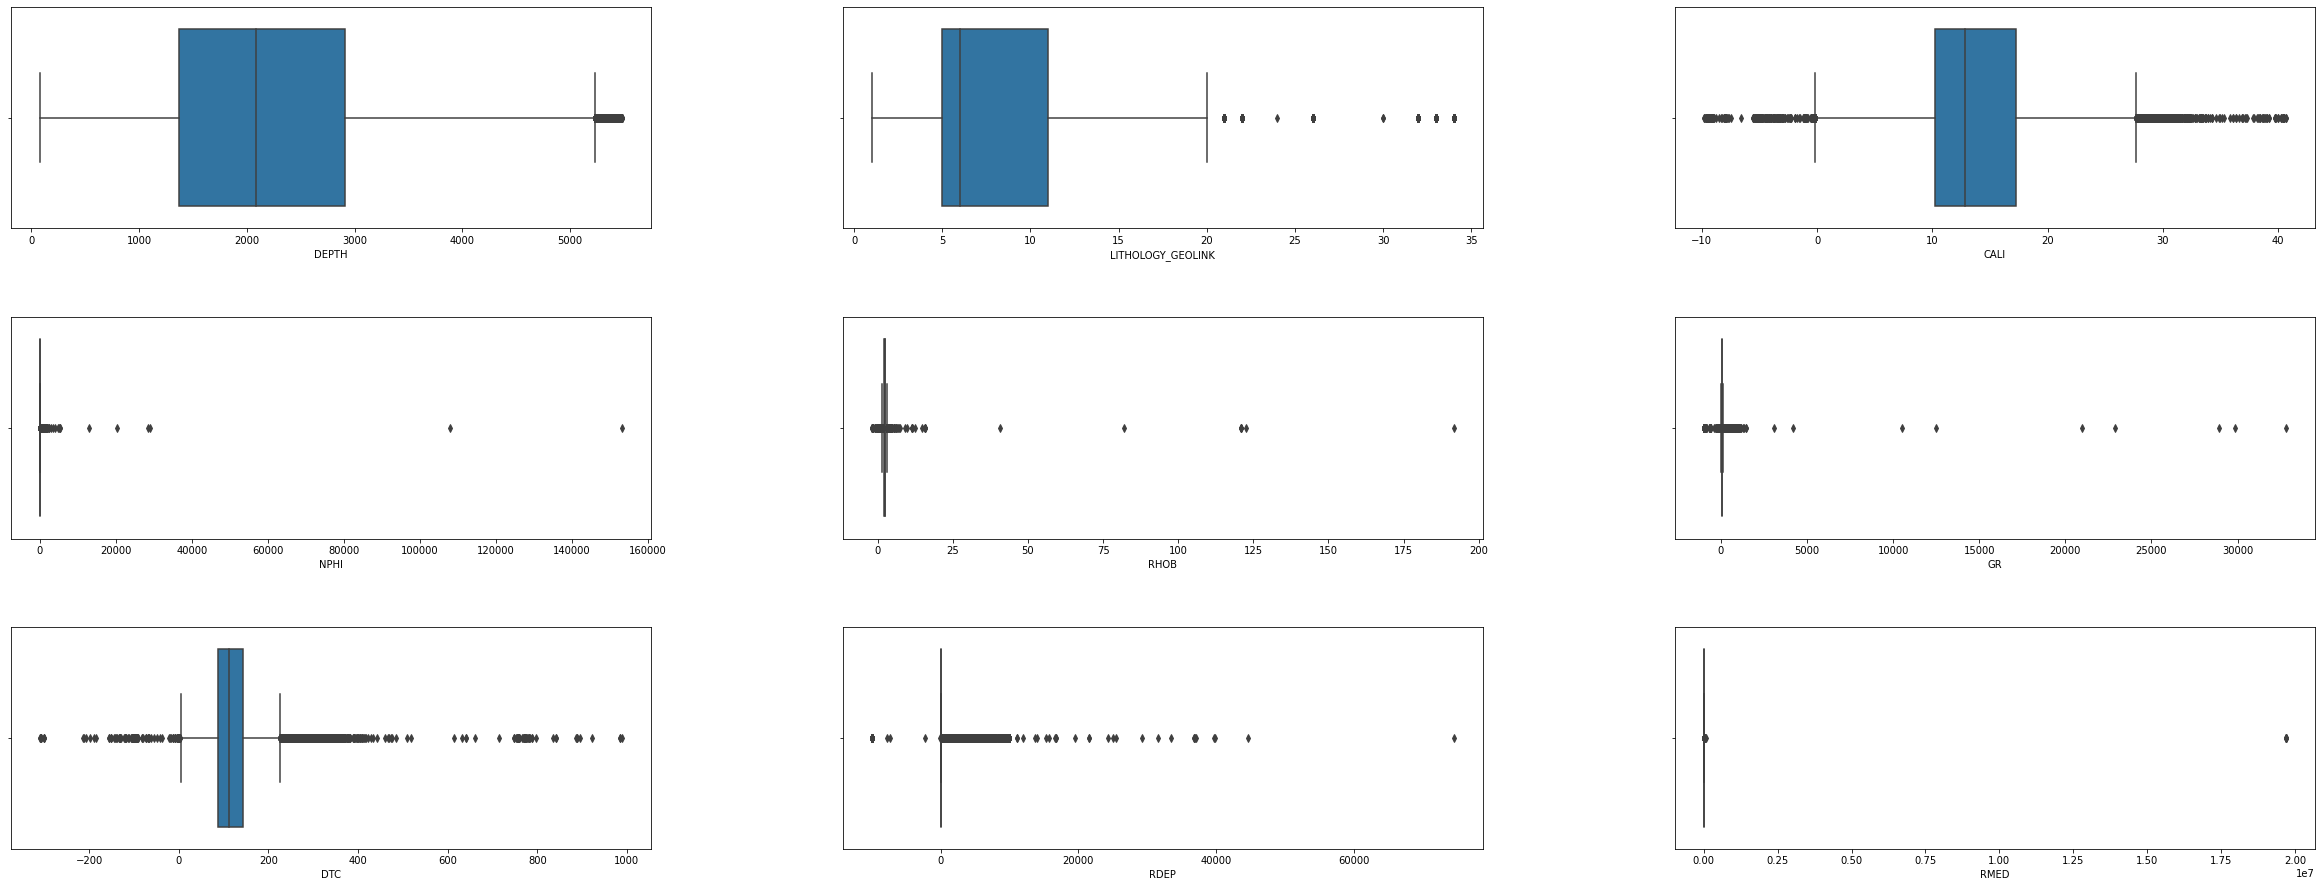

In [ ]:
#plotting the box plots of the features values = logs values to visualize the outliers

cons_feat = df_main.columns                                         #a list of all features without the 'WELL_NAME'

plt.figure(figsize=(40,20))

for i in range(len(cons_feat)):
  if cons_feat[i] != 'WELL_NAME' :
    plt.subplot(4,3,(i+1))
    sns.boxplot(df_main[cons_feat[i]])
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)

plt.show()



---



In [ ]:
#Detecting the outliers using IQR value
Q1 = df_main.quantile(0.25)
Q3 = df_main.quantile(0.75)
IQR = Q3 - Q1                                                 # iqr value for each column

#print(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))         # a df of True or False values in place of each outlier value
df_without_out_iqr = df_main[~((df_main < (Q1 - 1.5*IQR)) | (df_main > (Q3 + 1.5*IQR))).any(axis=1)]

rem_rows = df_main.shape[0] - df_without_out_iqr.shape[0]
rem_perc = rem_rows / df_without_out_iqr.shape[0] * 100
print("Total number of rows deleted due to Outliers removal is :" , (rem_rows) , " out of " , df_main.shape[0] , "about " , rem_perc , "%")

Total number of rows deleted due to Outliers removal is : 569933  out of  3147162 about  22.114177669116714 %




---



⚓ 22% is a huge ammount of data to remove, let's figure out the ammounts of outliers in each column

In [ ]:
cons_feat = df_main.columns                                         #a list of all features without the 'WELL_NAME'

for i in range(len(df_main.columns)):
  if cons_feat[i] != 'WELL_NAME' :
    Q1 = df_main[ cons_feat[i] ].quantile(0.25)
    Q3 = df_main[ cons_feat[i] ].quantile(0.75)
    IQR = Q3 - Q1
    out_df = df_main[cons_feat[i]][~((df_main[cons_feat[i]] < (Q1 - 1.5*IQR)) | (df_main[cons_feat[i]] > (Q3 + 1.5*IQR)))]      # a new df without the outliers of column i only
    
    with_outl = len(df_main[cons_feat[i]])
    without_outl = len(out_df)

    rem_rows = with_outl - without_outl
    rem_perc = rem_rows / with_outl * 100

    print("the number of outliers in " , cons_feat[i] , " is " , (with_outl - without_outl) , " out of " , with_outl , "about " , "{:.3f}".format(rem_perc) , "%" )
    

the number of outliers in  DEPTH  is  3144  out of  3147162 about  0.100 %
the number of outliers in  LITHOLOGY_GEOLINK  is  36857  out of  3147162 about  1.171 %
the number of outliers in  CALI  is  2710  out of  3147162 about  0.086 %
the number of outliers in  NPHI  is  74936  out of  3147162 about  2.381 %
the number of outliers in  RHOB  is  15465  out of  3147162 about  0.491 %
the number of outliers in  GR  is  57461  out of  3147162 about  1.826 %
the number of outliers in  DTC  is  9246  out of  3147162 about  0.294 %
the number of outliers in  RDEP  is  363453  out of  3147162 about  11.549 %
the number of outliers in  RMED  is  362047  out of  3147162 about  11.504 %




---



In [ ]:
#If we do not want to remove the outliers, we should not run this cell
df_main = df_without_out_iqr



---



## Missing Values

In [ ]:
df_main.isnull().sum()

DEPTH                      0
LITHOLOGY_GEOLINK    1407692
CALI                  174544
NPHI                 1136819
RHOB                  324003
GR                     34669
DTC                   177378
RDEP                   57131
RMED                  153896
WELL_NAME                  0
dtype: int64

In [ ]:
cols = df_main.columns.to_list()

cols.remove('LITHOLOGY_GEOLINK')
cols.remove('DEPTH')
cols.remove('WELL_NAME')
cols

['CALI', 'NPHI', 'RHOB', 'GR', 'DTC', 'RDEP', 'RMED']

Text(0.5, 1.0, 'Total missing values (Not a Number)')

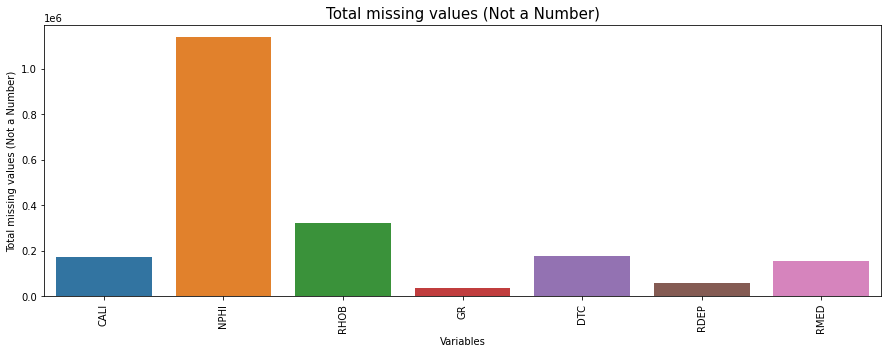

In [ ]:
plt.figure(figsize=(15,5))

sns.barplot(x=df_main[cols].isnull().sum().index, y=df_main[cols].isnull().sum())
plt.xticks(rotation='90')
plt.xlabel('Variables', fontsize=10)
plt.ylabel('Total missing values (Not a Number)', fontsize=10) 
plt.title('Total missing values (Not a Number)', fontsize=15) 

In [ ]:
#Dropping Null Values of Low Percentage Presence
list_nulls = ['CALI', 'RHOB', 'GR', 'DTC', 'RDEP', 'RMED']
df_main = df_main.dropna(subset=list_nulls)
df_main.isnull().sum()

DEPTH                      0
LITHOLOGY_GEOLINK    1064761
CALI                       0
NPHI                  728307
RHOB                       0
GR                         0
DTC                        0
RDEP                       0
RMED                       0
WELL_NAME                  0
dtype: int64

In [ ]:
len(df_main)

2029722

In [ ]:
#saving the datasets
path_file_lito_code = '/content/gdrive/MyDrive/Dev tools/Data - NorthSea Electrofacies/Generated Dataframes/litho_code.csv.gz'

path_file_df_main = '/content/gdrive/MyDrive/Dev tools/Data - NorthSea Electrofacies/Generated Dataframes/df_main.csv.gz'

litho_code.to_csv(path_file_lito_code,index=False, compression='gzip')

df_main.to_csv(path_file_df_main,index=False, compression='gzip')



---

